# All Model Errors

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [3]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [4]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [5]:
EXPERIMENT =        'one_timestep_forecast'
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

# assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"RUNOFF/features/{TRUE_EXPERIMENT}").exists()

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / f'RUNOFF/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}')

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [7]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

# Read AWS Trained Models

In [8]:
print([d.name for d in (data_dir/'runs/').iterdir()])
print([d.name for d in (data_dir/'runs').glob('*_less_vars*/*E015.csv')])

['ealstm_less_vars_2004_1607_1334', 'lstm_less_vars_1307_1717', 'ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p']
['results_lstm_less_vars_1307_1717_E015.csv', 'results_ealstm_less_vars_2004_1707_1424_E015.csv', 'results_lstm_less_vars_2004_1507_1028_E015.csv']


In [9]:
# lstm_less_vars = pd.read_csv(data_dir / "RUNOFF/lstm_less_vars/results_lstm_less_vars_1307_1717_E015.csv")
lstm_less_vars = pd.read_csv(data_dir / "runs/lstm_less_vars_2004_1507_1028/results_lstm_less_vars_2004_1507_1028_E015.csv")
# lstm_less_vars = lstm_less_vars[["station_id", "time", "obs", "sim_E015"]].rename(columns=dict(sim_E015="sim"))
lstm_less_vars["time"] = pd.to_datetime(lstm_less_vars["time"])

In [10]:
ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_less_vars["time"] = pd.to_datetime(ealstm_less_vars["time"])

In [11]:
lstm_preds = lstm_less_vars.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_less_vars.set_index(["station_id", "time"]).to_xarray()

In [12]:
lstm_preds

<xarray.Dataset>
Dimensions:     (station_id: 667, time: 4291)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2015-09-30
Data variables:
    obs         (station_id, time) float64 9.16 6.23 5.6 4.45 ... 0.63 0.55 0.52
    sim         (station_id, time) float64 10.03 5.819 5.267 ... 0.7127 0.6411

# FUSE Data

In [13]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [14]:
fuse_ds = fuse_ds.sel(time=slice('2004-01-01', '2009-01-01'))

In [15]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["target_var_original"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [16]:
fuse_data

<xarray.Dataset>
Dimensions:          (station_id: 519, time: 1827)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Match Stations / Times

In [17]:
all_stations = np.isin(lstm_preds.station_id, fuse_data.station_id)

In [18]:
lstm_preds = lstm_preds.sel(station_id=all_stations, time=fuse_data.time)
ealstm_preds = ealstm_preds.sel(station_id=all_stations, time=fuse_data.time)

# Errors

In [19]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse, spatial_bias
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func, _bias_func

In [20]:
def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
        "bias": _bias_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [21]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
    error_func(ealstm_preds, "bias").set_index('station_id'),
]
ealstm_df = errors[0].join(errors[1].join(errors[2]).join(errors[3])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
    error_func(lstm_preds, "bias").set_index('station_id'),
]
lstm_df = errors[0].join(errors[1].join(errors[2]).join(errors[3])).reset_index()

In [22]:
ealstm_nse = (
    error_func(ealstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
lstm_nse = (
    error_func(lstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
ealstm_nse['negative'] = ealstm_nse['nse'] < 0
lstm_nse['negative'] = lstm_nse['nse'] < 0

### FUSE

In [23]:
obs = fuse_data["obs"].transpose("station_id", "time")
topmodel = fuse_data["SimQ_TOPMODEL"]
arnovic = fuse_data["SimQ_ARNOVIC"]
prms = fuse_data["SimQ_PRMS"]
sacramento = fuse_data["SimQ_SACRAMENTO"]

In [24]:
top_nse = spatial_nse(obs, topmodel).rename("TOPMODEL")
vic_nse = spatial_nse(obs, arnovic).rename("VIC")
prms_nse = spatial_nse(obs, prms).rename("PRMS")
sac_nse = spatial_nse(obs, sacramento).rename("Sacramento")

In [25]:
nse = xr.merge([
    top_nse,
    vic_nse,
    prms_nse,
    sac_nse,
])
nse_df = nse.to_dataframe()
nse_df = static['gauge_name'].to_dataframe().join(nse_df).rename(columns=dict(gauge_name="Name"))
nse_df.to_csv(data_dir / 'RUNOFF/FUSE_nse_table.csv')
nse_df.columns = [["nse" for _ in range(len(nse_df.columns))], nse_df.columns]


In [26]:
top_rmse = spatial_rmse(obs, topmodel).rename("TOPMODEL")
vic_rmse = spatial_rmse(obs, arnovic).rename("VIC")
prms_rmse = spatial_rmse(obs, prms).rename("PRMS")
sac_rmse = spatial_rmse(obs, sacramento).rename("Sacramento")

rmse = xr.merge([
    top_rmse,
    vic_rmse,
    prms_rmse,
    sac_rmse,
])
rmse_df = rmse.to_dataframe().drop(columns='time')
rmse_df.to_csv(data_dir / 'RUNOFF/FUSE_rmse_table.csv')
rmse_df.columns = [["rmse" for _ in range(len(rmse_df.columns))], rmse_df.columns]


In [27]:
top_r2 = spatial_r2(obs, topmodel).rename("TOPMODEL")
vic_r2 = spatial_r2(obs, arnovic).rename("VIC")
prms_r2 = spatial_r2(obs, prms).rename("PRMS")
sac_r2 = spatial_r2(obs, sacramento).rename("Sacramento")

r2 = xr.merge([
    top_r2,
    vic_r2,
    prms_r2,
    sac_r2,
])
r2_df = r2.to_dataframe().drop(columns='time')
r2_df.to_csv(data_dir / 'RUNOFF/FUSE_r2_table.csv')
r2_df.columns = [["r2" for _ in range(len(r2_df.columns))], r2_df.columns]

In [28]:
top_bias = spatial_bias(obs, topmodel).rename("TOPMODEL")
vic_bias = spatial_bias(obs, arnovic).rename("VIC")
prms_bias = spatial_bias(obs, prms).rename("PRMS")
sac_bias = spatial_bias(obs, sacramento).rename("Sacramento")

bias = xr.merge([
    top_bias,
    vic_bias,
    prms_bias,
    sac_bias,
])
bias_df = bias.to_dataframe()
bias_df.to_csv(data_dir / 'RUNOFF/FUSE_bias_table.csv')
bias_df.columns = [["bias" for _ in range(len(bias_df.columns))], bias_df.columns]

In [29]:
fuse_errors = pd.concat([nse_df, rmse_df, r2_df, bias_df], axis=1)
try:
    fuse_errors = fuse_errors.drop('time', axis=1, level=1).swaplevel(axis=1).sort_index(axis=1)
except KeyError:
    pass
fuse_errors.to_csv(data_dir / 'RUNOFF/FUSE_errors.csv')
fuse_errors.to_pickle(data_dir / 'RUNOFF/FUSE_errors.pkl')

In [30]:
fuse_nse_df = fuse_errors.drop(['bias', 'r2', 'rmse'], axis=1, level=0).droplevel(axis=1, level=0)
fuse_bias = fuse_errors.drop(['nse', 'r2', 'rmse'], axis=1, level=0).droplevel(axis=1, level=0)

In [31]:
fuse_nse_df.head()

,Name,TOPMODEL,VIC,PRMS,Sacramento
station_id,,,,,
1001,Wick at Tarroul,0.806001,0.782846,0.810740,0.833511
2001,Helmsdale at Kilphedir,0.702887,0.724460,0.733039,0.745913
2002,Brora at Bruachrobie,0.759962,0.731940,0.754227,0.753752
3003,Oykel at Easter Turnaig,0.826229,0.818363,0.820548,0.830304
4001,Conon at Moy Bridge,0.730351,0.814088,0.761567,0.794666


# Overall Model Performance Comparison

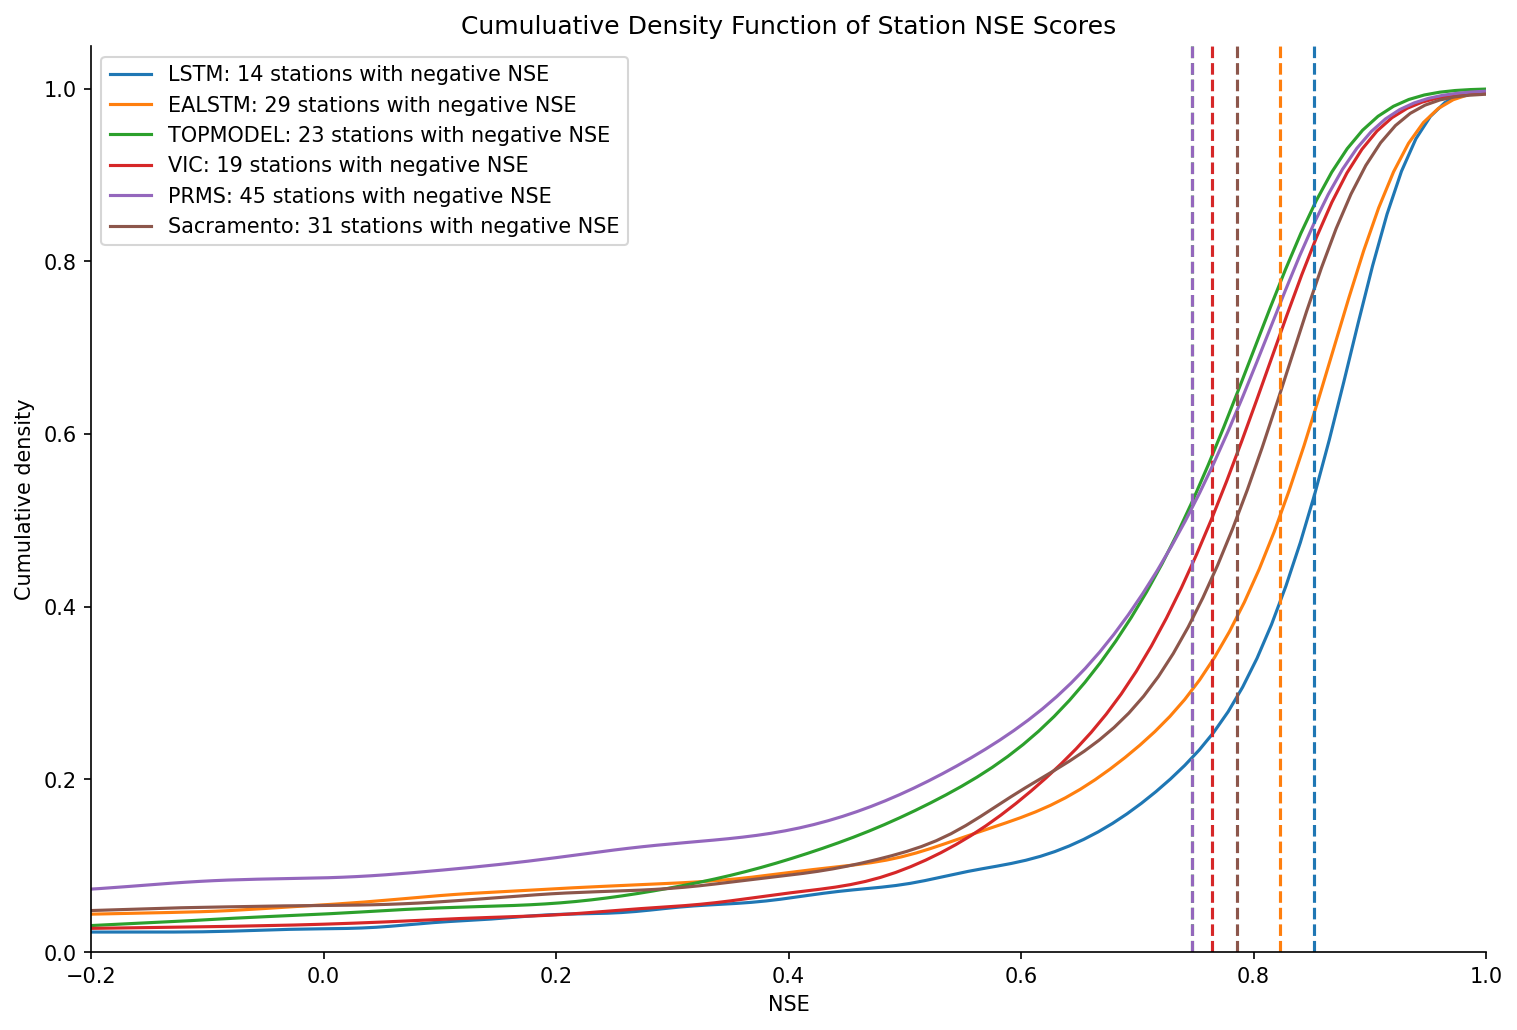

In [32]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"LSTM: {lstm_nse['negative'].sum()} stations with negative NSE"
)
sns.kdeplot(
    ealstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"EALSTM: {ealstm_nse['negative'].sum()} stations with negative NSE"
)

for conceptual_ix, model in enumerate([c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]):
    sns.kdeplot(
        fuse_nse_df[model].dropna(), 
        cumulative=True, 
        legend=False, ax=ax, 
        clip=[-0.5,1], 
        label=f"{model}: {(fuse_nse_df[model] < 0).sum()} stations with negative NSE"
    )
    plt.legend()
    ax.axvline(fuse_nse_df[model].dropna().median(), ls="--", color=colors[conceptual_ix+2])


ax.axvline(lstm_nse['nse'].median(), ls="--", color=colors[0])
ax.axvline(ealstm_nse['nse'].median(), ls="--", color=colors[1])

ax.set_xlim([-0.2, 1])
ax.set_xlabel("NSE")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station NSE Scores"
ax.set_title(title)
sns.despine()

# Bias

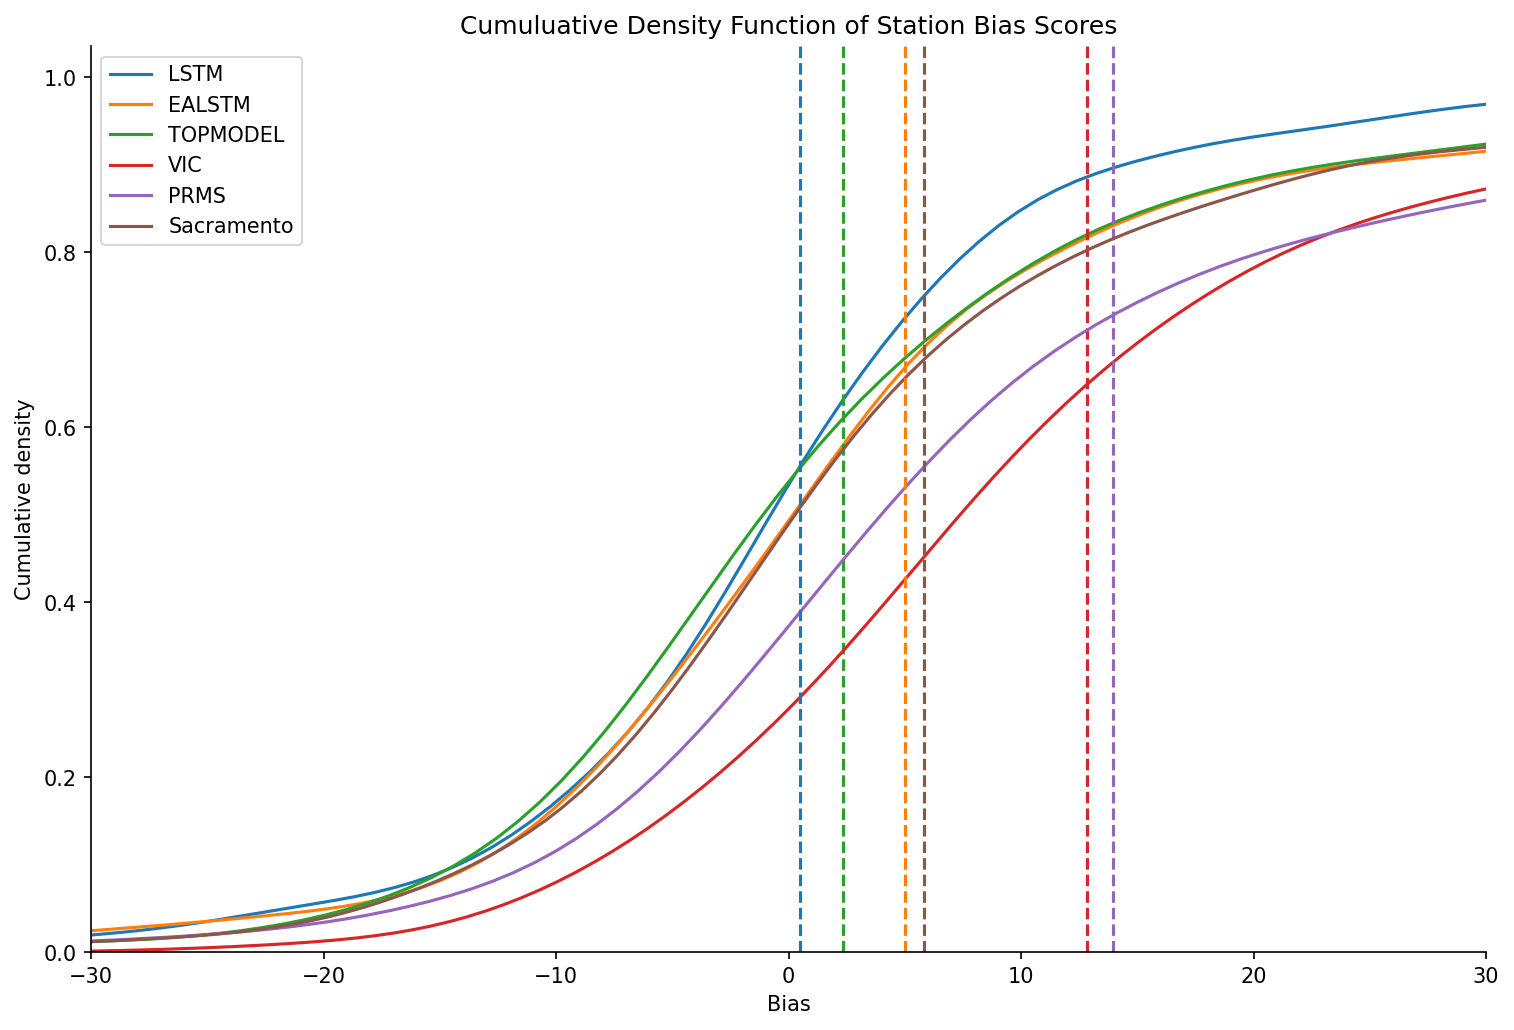

In [33]:
colors = sns.color_palette()
cumulative = True

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_df['bias'], 
    cumulative=cumulative, 
    legend=False, ax=ax, 
    clip=[-50, 50], 
    label=f"LSTM"
)
sns.kdeplot(
    ealstm_df['bias'],
    cumulative=cumulative, 
    legend=False, ax=ax, 
    clip=[-50, 50], 
    label=f"EALSTM"
)

for conceptual_ix, model in enumerate([model for model in fuse_bias]):
    sns.kdeplot(
        fuse_bias[model].dropna(), 
        cumulative=cumulative, 
        legend=False, ax=ax, 
        label=f"{model}",
        clip=[-50,50],
    )
    plt.legend()
    ax.axvline(fuse_bias[model].dropna().mean(), ls="--", color=colors[conceptual_ix+2])


ax.axvline(lstm_df['bias'].mean(), ls="--", color=colors[0])
ax.axvline(ealstm_df['bias'].mean(), ls="--", color=colors[1])

ax.set_xlim([-30, 30])
ax.set_xlabel("Bias")

if cumulative:
    ax.set_ylabel("Cumulative density")
    title = f"Cumuluative Density Function of Station Bias Scores"
else:
    title = f"Density of Station Bias Scores"
    ax.set_ylabel("Density")
# ax.axvline(ls="--", color='grey', ) # label="Zero Bias", 
ax.set_title(title)
plt.legend()
sns.despine()

In [34]:
print(f"LSTM Bias: {lstm_df['bias'].mean():.2f}")
print(f"EALSTM Bias: {ealstm_df['bias'].mean():.2f}")

for model in [model for model in fuse_bias]:
    print(f"{model} Bias: {fuse_bias[model].dropna().mean():.2f}")

LSTM Bias: 0.48
EALSTM Bias: 5.02
TOPMODEL Bias: 2.34
VIC Bias: 12.82
PRMS Bias: 13.96
Sacramento Bias: 5.82


# Tables

In [35]:
process_errors = pd.read_csv(data_dir / "RUNOFF/jules_classic.csv")

classic = process_errors.loc[process_errors["Model"] == "Classic", :].drop('Model', axis=1)
classic = classic.rename(columns={"ID": "Station ID"}).set_index("Station ID")
classic.columns = [["CLASSIC" for _ in range(len(classic.columns))], classic.columns]

jules = process_errors.loc[process_errors["Model"] == "Jules", :].drop('Model', axis=1)
jules = jules.rename(columns={"ID": "Station ID"}).set_index("Station ID").drop("Name", axis=1)
jules.columns = [["JULES" for _ in range(len(jules.columns))], jules.columns]

process_errors = pd.concat([classic, jules], axis=1)
process_errors.to_pickle(data_dir / "RUNOFF/process_models.pkl")
process_errors

CLASSIC             JULES      
                                  Name   NSE  Bias   NSE  Bias
Station ID                                                    
12002                     Dee at Park   0.55  -3.4  0.51 -20.0
15006                Tay at Ballathie   0.46  -7.7  0.64 -15.0
27009                 Ouse at Skelton   0.80   3.1  0.69 -18.0
27034           Ure at Kilgram Bridge   0.78   2.8  0.75 -19.0
27041         Derwent at Buttercrambe   0.65  -5.3  0.49 -27.0
39001              Thames at Kingston   0.81  -5.9  0.82 -11.0
39081                 Ock at Abingdon   0.80 -13.6 -0.21 -63.0
43021              Avon at Knapp Mill   0.60 -17.6 -0.07 -20.0
47001             Tamar at Gunnislake   0.82   0.6  0.63 -18.0
54001               Severn at Bewdley   0.66   4.6  0.61  -7.0
54057            Severn at Haw Bridge   0.78   2.1  0.72 -14.0
71001            Ribble at Samlesbury   0.73   0.4  0.74 -18.0
84013               Clyde at Daldowie   0.80  -2.5  0.82 -24.0

In [36]:
fuse_nse = fuse_errors.drop(["rmse", "bias", "r2"], axis=1, level=0).droplevel(axis=1, level=0)
fuse_rmse = fuse_errors.drop(["nse", "bias", "r2"], axis=1, level=0).droplevel(axis=1, level=0)
fuse_bias = fuse_errors.drop(["rmse", "nse", "r2"], axis=1, level=0).droplevel(axis=1, level=0)
fuse_r2 = fuse_errors.drop(["rmse", "bias", "nse"], axis=1, level=0).droplevel(axis=1, level=0)

fuse_nse = fuse_nse.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1).iloc[:, :-1]
fuse_rmse = fuse_rmse.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1).iloc[:, :-1]
fuse_bias = fuse_bias.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1).iloc[:, :-1]
fuse_r2 = fuse_r2.join(fuse_errors.iloc[:, 0]).rename({("Name", "nse"): 'Name'}, axis=1).iloc[:, :-1]

fuse_r2.head()

,TOPMODEL,VIC,PRMS,Sacramento
station_id,,,,
1001,0.810045,0.793952,0.817980,0.837989
2001,0.705835,0.724673,0.733852,0.747653
2002,0.767793,0.736381,0.759652,0.760744
3003,0.853730,0.843974,0.847016,0.856462
4001,0.853066,0.893877,0.866271,0.886876


In [37]:
# NSE
nse = fuse_nse_df.join(
    ealstm_df.set_index("station_id")["nse"].rename("EALSTM")
)
nse = nse.join(
    lstm_df.set_index("station_id")["nse"].rename("LSTM")
)

# RMSE
rmse = fuse_rmse.join(
    ealstm_df.set_index("station_id")["rmse"].rename("EALSTM")
)
rmse = rmse.join(
    lstm_df.set_index("station_id")["rmse"].rename("LSTM")
)
rmse['Name'] = nse["Name"]
rmse = rmse[["Name"] + [c for c in rmse.columns if c != "Name"]]

# R2
r2 = fuse_r2.join(
    ealstm_df.set_index("station_id")["r2"].rename("EALSTM")
)
r2 = r2.join(
    lstm_df.set_index("station_id")["r2"].rename("LSTM")
)
r2['Name'] = nse["Name"]
r2 = r2[["Name"] + [c for c in r2.columns if c != "Name"]]


# BIAS
bias = fuse_bias.join(
    ealstm_df.set_index("station_id")["bias"].rename("EALSTM")
)
bias = bias.join(
    lstm_df.set_index("station_id")["bias"].rename("LSTM")
)
bias['Name'] = nse["Name"]
bias = bias[["Name"] + [c for c in bias.columns if c != "Name"]]

In [38]:
nse_13 = nse.loc[catchment_ids]
nse_13.index.name = "Station ID"
rmse_13 = rmse.loc[catchment_ids]
rmse_13.index.name = "Station ID"
r2_13 = r2.loc[catchment_ids]
r2_13.index.name = "Station ID"
bias_13 = bias.loc[catchment_ids]
bias_13.index.name = "Station ID"

In [39]:
all_bias = bias_13.join(process_errors.drop(["NSE", "Name"], axis=1, level=1).droplevel(axis=1, level=1))

In [40]:
all_nse = nse_13.join(process_errors.drop(["Bias", "Name"], axis=1, level=1).droplevel(axis=1, level=1))

In [41]:
print(all_nse.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                     Name &  TOPMODEL &  VIC &  PRMS &  Sacramento &  EALSTM &  LSTM &  CLASSIC &  JULES \\
Station ID &                          &           &      &       &             &         &       &          &        \\
\midrule
12002      &              Dee at Park &      0.56 & 0.63 &  0.65 &        0.65 &    0.86 &  0.87 &     0.55 &   0.51 \\
15006      &         Tay at Ballathie &      0.80 & 0.89 &  0.86 &        0.88 &    0.92 &  0.94 &     0.46 &   0.64 \\
27009      &          Ouse at Skelton &      0.86 & 0.89 &  0.88 &        0.90 &    0.88 &  0.91 &     0.80 &   0.69 \\
27034      &    Ure at Kilgram Bridge &      0.84 & 0.85 &  0.85 &        0.85 &    0.87 &  0.85 &     0.78 &   0.75 \\
27041      &  Derwent at Buttercrambe &      0.75 & 0.71 &  0.78 &        0.81 &    0.75 &  0.84 &     0.65 &   0.49 \\
39001      &       Thames at Kingston &      0.73 & 0.73 &  0.63 &        0.82 &    0.74 &  0.87 &     0.81 &   0.82 \\
39

In [42]:
print(all_bias.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                     Name &  TOPMODEL &    VIC &  PRMS &  Sacramento &  EALSTM &   LSTM &  CLASSIC &  JULES \\
Station ID &                          &           &        &       &             &         &        &          &        \\
\midrule
12002      &              Dee at Park &     -5.94 &   7.12 & -3.04 &       -7.21 &    5.78 &  -0.37 &    -3.40 & -20.00 \\
15006      &         Tay at Ballathie &     -8.81 &   7.22 & -7.01 &       -8.62 &   -6.60 &  -6.47 &    -7.70 & -15.00 \\
27009      &          Ouse at Skelton &      3.98 &   8.81 &  3.04 &        3.38 &   -4.91 &  -4.56 &     3.10 & -18.00 \\
27034      &    Ure at Kilgram Bridge &     -6.60 &  -3.46 & -0.92 &       -9.45 &   -0.20 &  -2.93 &     2.80 & -19.00 \\
27041      &  Derwent at Buttercrambe &      1.41 &  20.46 & 10.31 &       10.90 &   -3.12 & -11.70 &    -5.30 & -27.00 \\
39001      &       Thames at Kingston &     16.53 &  17.65 & 46.28 &       21.18 &   22.52 &   9.25 &

# Spatial Plots

In [43]:
fuse_errors.head()

nse                                           \
                               Name  TOPMODEL       VIC      PRMS Sacramento   
station_id                                                                     
1001                Wick at Tarroul  0.806001  0.782846  0.810740   0.833511   
2001         Helmsdale at Kilphedir  0.702887  0.724460  0.733039   0.745913   
2002           Brora at Bruachrobie  0.759962  0.731940  0.754227   0.753752   
3003        Oykel at Easter Turnaig  0.826229  0.818363  0.820548   0.830304   
4001            Conon at Moy Bridge  0.730351  0.814088  0.761567   0.794666   

                rmse                                       r2            \
            TOPMODEL       VIC      PRMS Sacramento  TOPMODEL       VIC   
station_id                                                                
1001        0.913054  0.966006  0.901831   0.845843  0.810045  0.793952   
2001        1.348697  1.298811  1.278431   1.247226  0.705835  0.724673   
2002        1.626535  1.718855  1.645850   1.647439  0.767793  0.736381   
3003        2.618600  2.677211  2.661060   2.587714  0.853730  0.843974   
4001        1.984275  1.647614  1.865888   1.731542  0.853066  0.893877   

                                      bias                                   
                PRMS Sacramento   TOPMODEL        VIC       PRMS Sacramento  
station_id                                                                   
1001        0.817980   0.837989   5.374468  16.555672  12.959633   9.154312  
2001        0.733852   0.747653  -9.247812  -4.731616  -1.387481 -10.049628  
2002        0.759652   0.760744  -7.768279  -2.018369  -3.620416  -5.275559  
3003        0.847016   0.856462  -1.354333  -0.665297   0.064970  -0.250514  
4001        0.866271   0.886876 -13.168926  -3.269556 -10.896440 -15.224478

In [44]:
vic_errors = fuse_errors.drop(['Name', 'PRMS', "Sacramento", "TOPMODEL"], axis=1, level=1).droplevel(axis=1, level=1)
prms_errors = fuse_errors.drop(['Name', 'VIC', "Sacramento", "TOPMODEL"], axis=1, level=1).droplevel(axis=1, level=1)
top_errors = fuse_errors.drop(['Name', 'PRMS', "Sacramento", "VIC"], axis=1, level=1).droplevel(axis=1, level=1)
sac_errors = fuse_errors.drop(['Name', 'PRMS', "VIC", "TOPMODEL"], axis=1, level=1).droplevel(axis=1, level=1)

In [45]:
sac_errors.head()

,nse,rmse,r2,bias
station_id,,,,
1001,0.833511,0.845843,0.837989,9.154312
2001,0.745913,1.247226,0.747653,-10.049628
2002,0.753752,1.647439,0.760744,-5.275559
3003,0.830304,2.587714,0.856462,-0.250514
4001,0.794666,1.731542,0.886876,-15.224478


# Create Geospatial Map

In [46]:
import geopandas as gpd

shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

In [47]:
# create spatial dataframe
assert lstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
lstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(lstm_df.set_index('station_id').join(static['p_mean'].to_dataframe()))
)

assert ealstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
ealstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(ealstm_df.set_index('station_id').join(static['p_mean'].to_dataframe()))
)


# CONCEPTUAL MODELS
assert vic_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
vic_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(vic_errors.join(static['p_mean'].to_dataframe()))
)

assert prms_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
prms_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(prms_errors.join(static['p_mean'].to_dataframe()))
)

assert top_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
top_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(top_errors.join(static['p_mean'].to_dataframe()))
)

assert sac_errors.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
sac_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(sac_errors.join(static['p_mean'].to_dataframe()))
)


lstm_gdf.crs = {'init' :'epsg:27700'}
ealstm_gdf.crs = {'init' :'epsg:27700'}
vic_gdf.crs = {'init' :'epsg:27700'}
prms_gdf.crs = {'init' :'epsg:27700'}
top_gdf.crs = {'init' :'epsg:27700'}
sac_gdf.crs = {'init' :'epsg:27700'}

## Get UK Boundaries

Get the COUNTY SHAPE data [here:](https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D)
```
!wget https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!unzip 1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!mkdir Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
!mv Counties* Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
```

Get all of these shapefiles and merge into one big polygon
```python
uk = gpd.read_file(data_dir / "RUNOFF/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC.shp")
uk.plot()

from shapely.ops import unary_union  # cascaded_union, 
uk_bound = unary_union([p for p in uk.geometry])
uk_bound = gpd.GeoSeries(uk_bound)
```

[Link to CRS Discussion](https://communityhub.esriuk.com/geoxchange/2012/3/26/coordinate-systems-and-projections-for-beginners.html#:~:text=If%20you%20work%20with%20UK,that%20you%20should%20know%20about.&text=Web%20Mercator%20is%20a%20PCS,36%20used%20for%20British%20maps)


![title](https://static1.squarespace.com/static/55bb8935e4b046642e9d3fa7/55bb8e8ee4b03fcc125a74c0/55bb8e91e4b03fcc125a7a67/1331725592717/1000w/coordsys_diagram.png)


In [48]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [49]:
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis'},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis'},   # rmse   
    "nse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # nse   
    "r2": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # r2  
    "bias": {"vmin": -30, "vmax": 30, 'cmap': 'RdBu'}    # r2  
}


def plot_geospatial_data(model_data, model: str):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    
    for ix, metric in enumerate(["rmse", "nse", "bias"]):
        ax = axs[ix]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

        # plot the surrounding lines
        uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
        # plot the chloropleth
        model_data.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts[metric]);

        ax.set_xlim([-8.2, 2.5])
        ax.axis('off');

        ax.set_title(metric.upper())

    fig.tight_layout(rect=[0, 0.03, 1, 0.965])
    fig.suptitle(f"{model} Model Error", size=14)

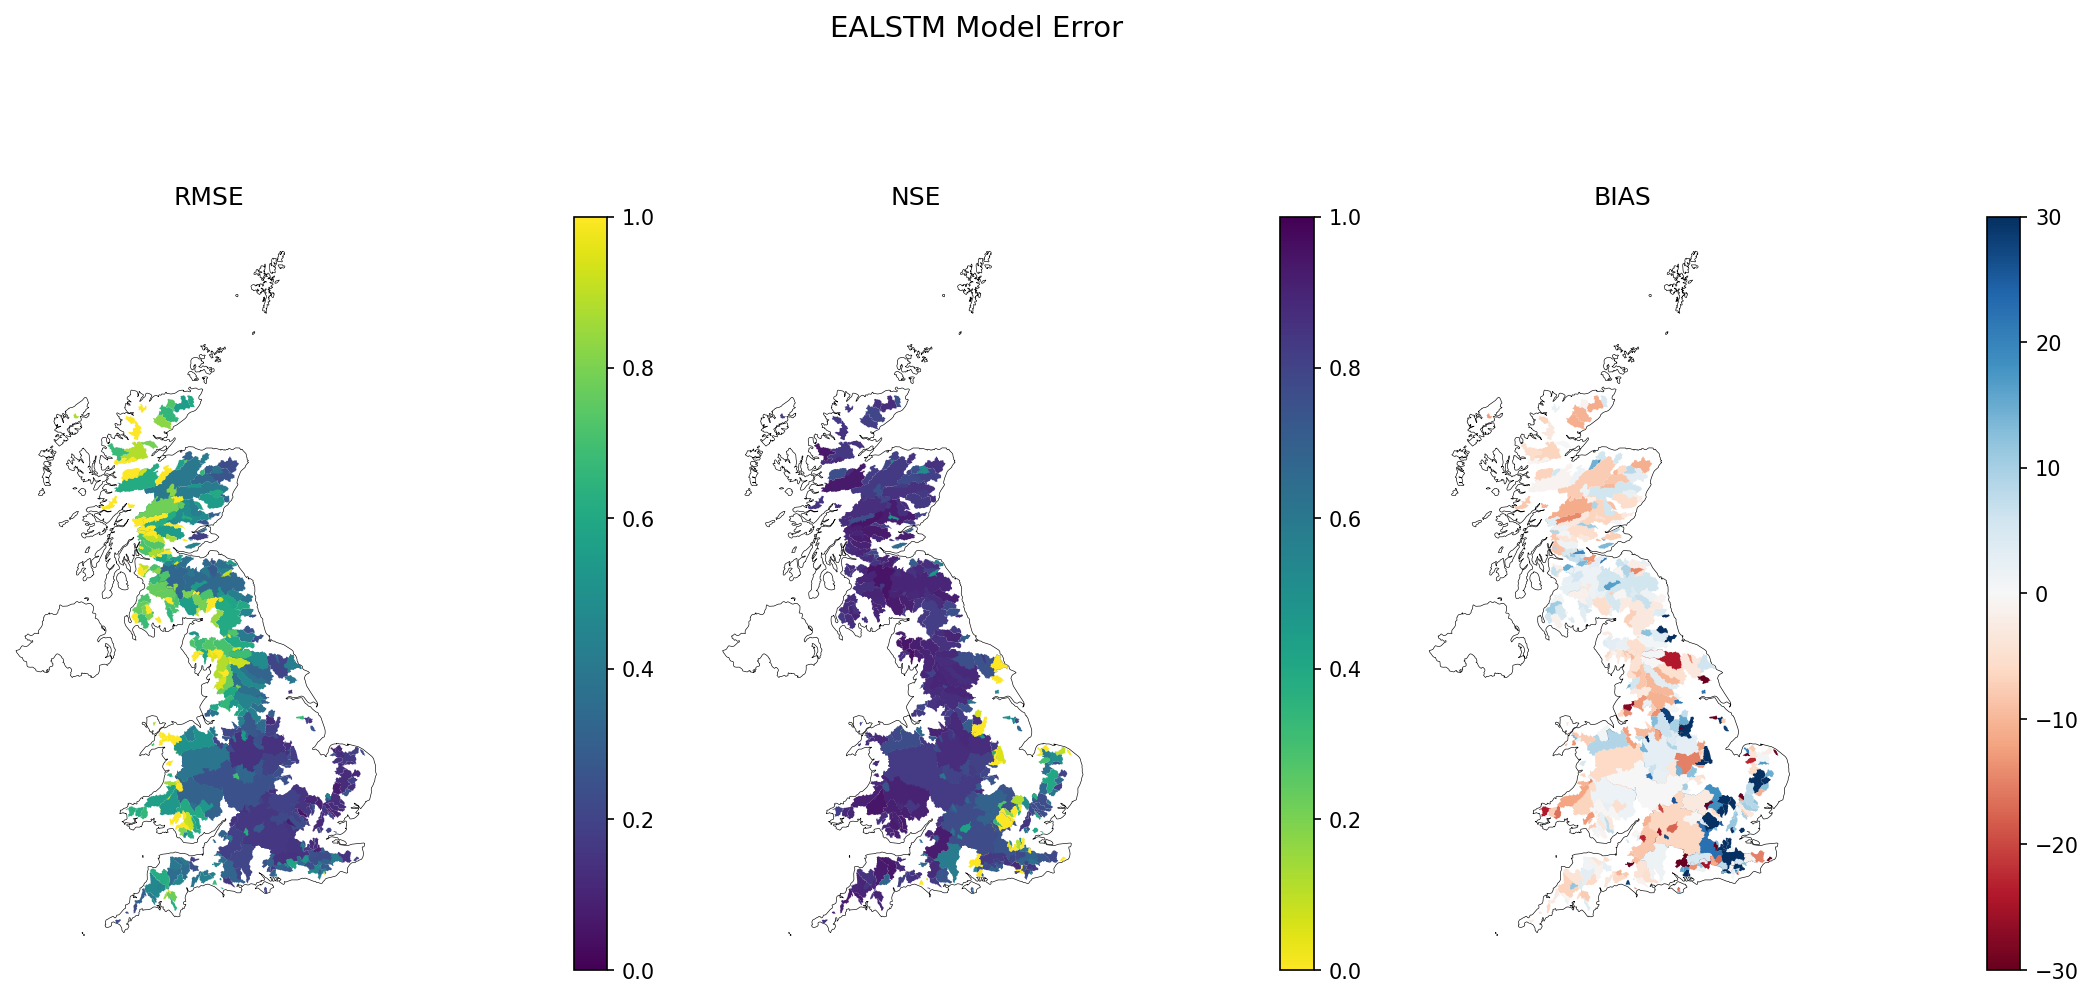

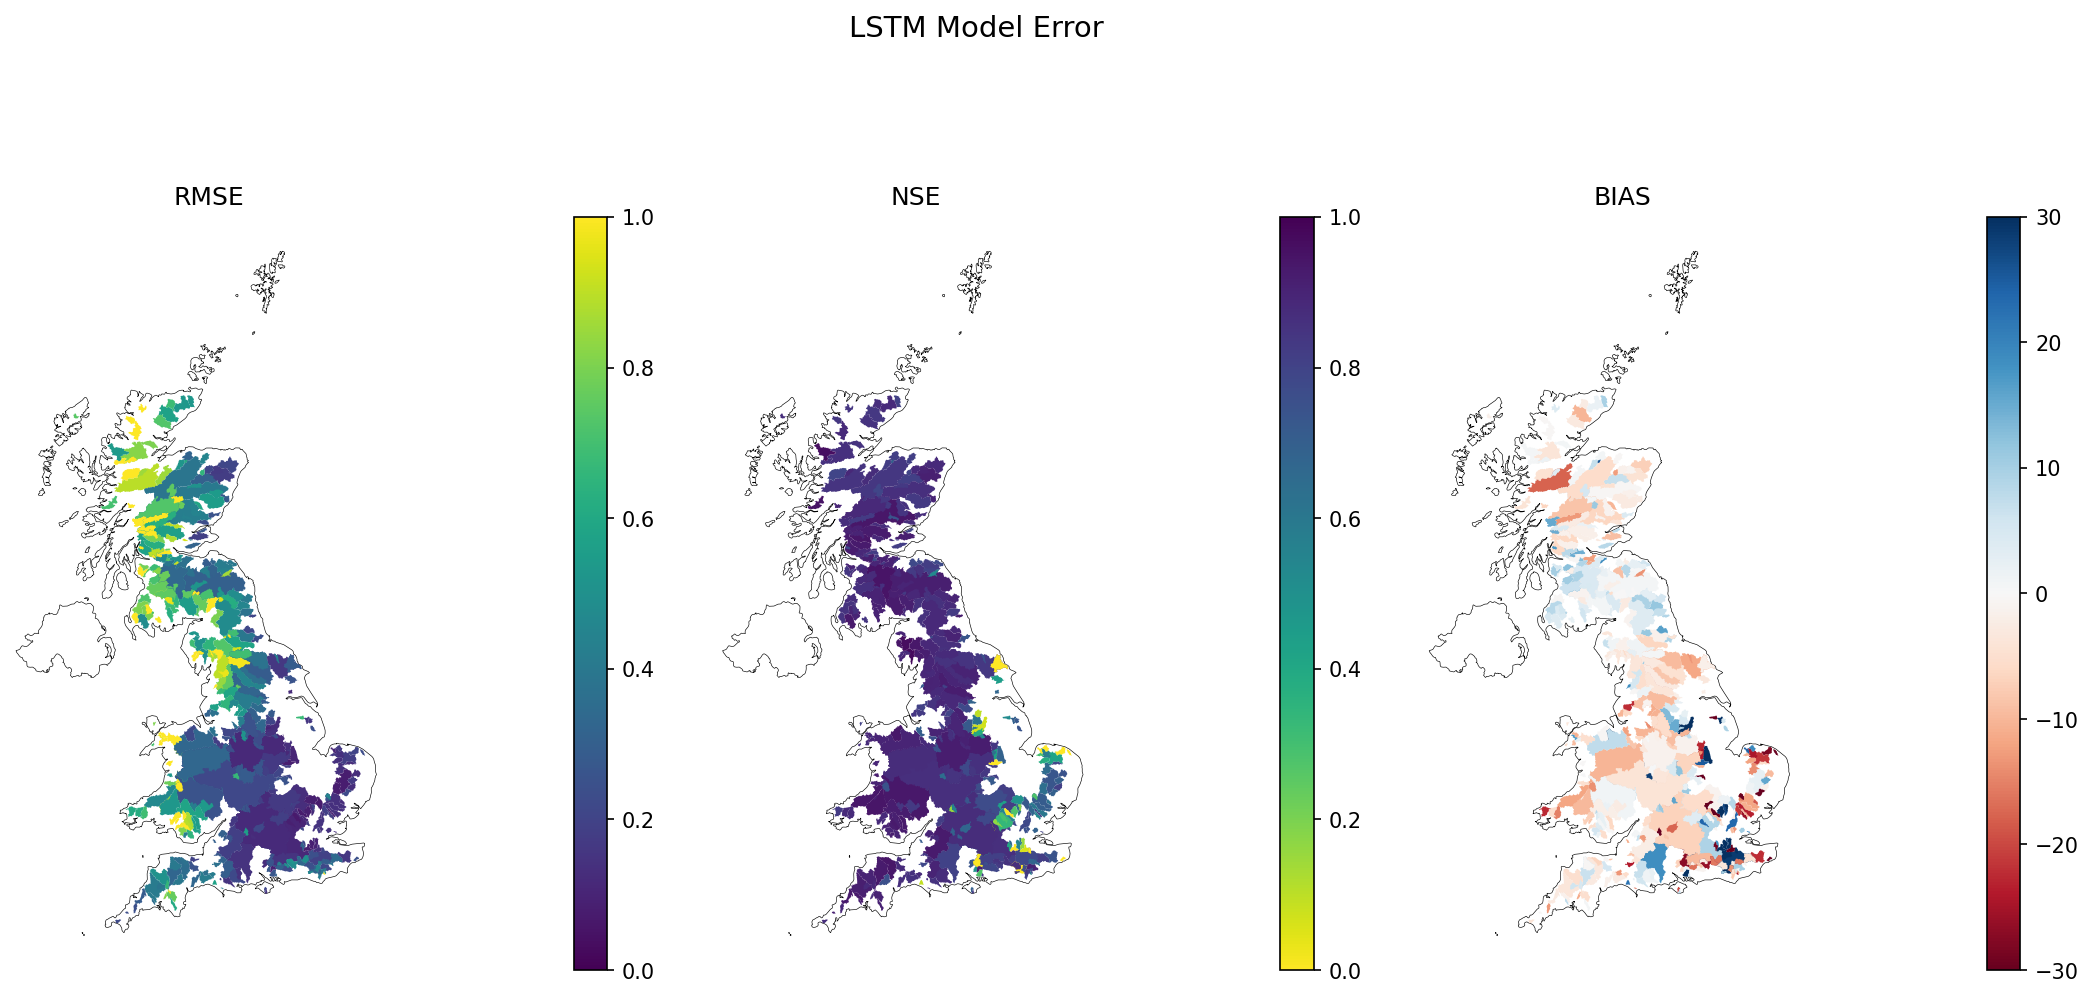

In [50]:
plot_geospatial_data(ealstm_gdf, model="EALSTM")
plot_geospatial_data(lstm_gdf, model="LSTM")

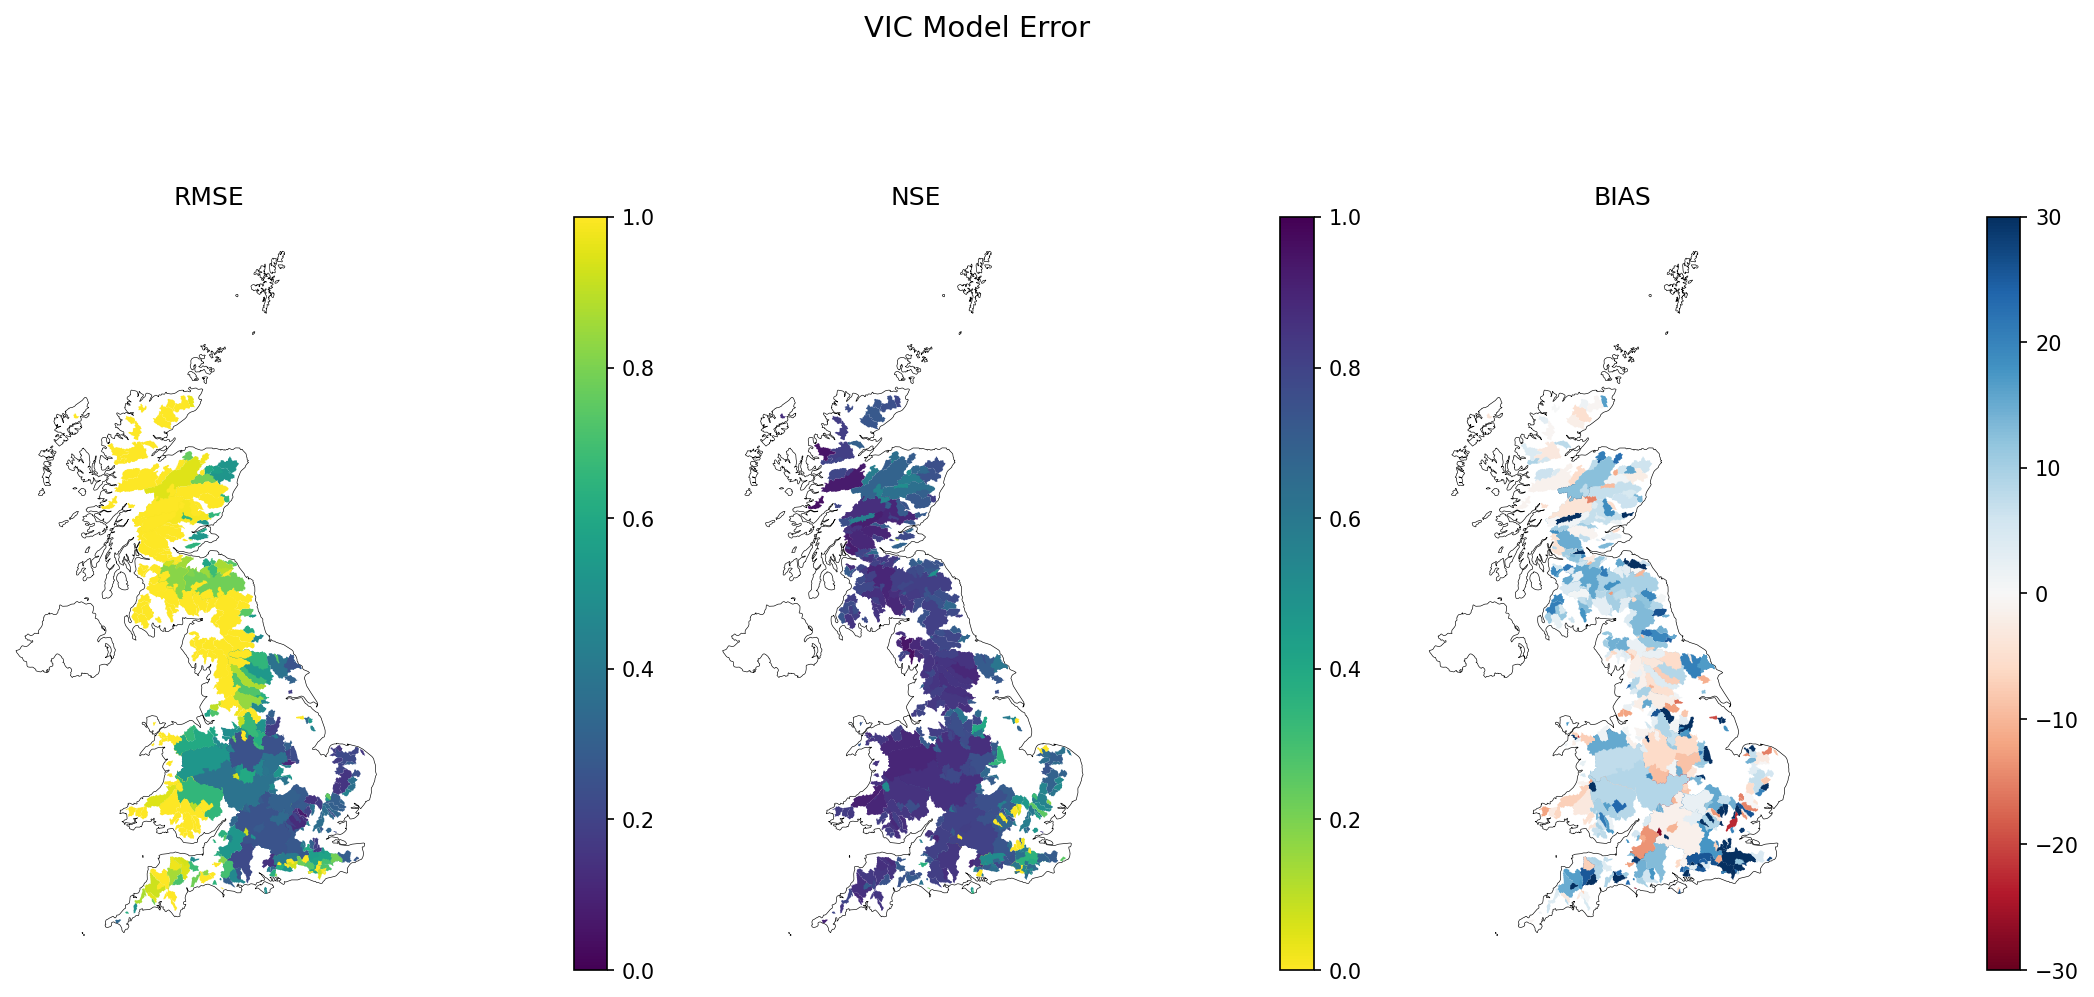

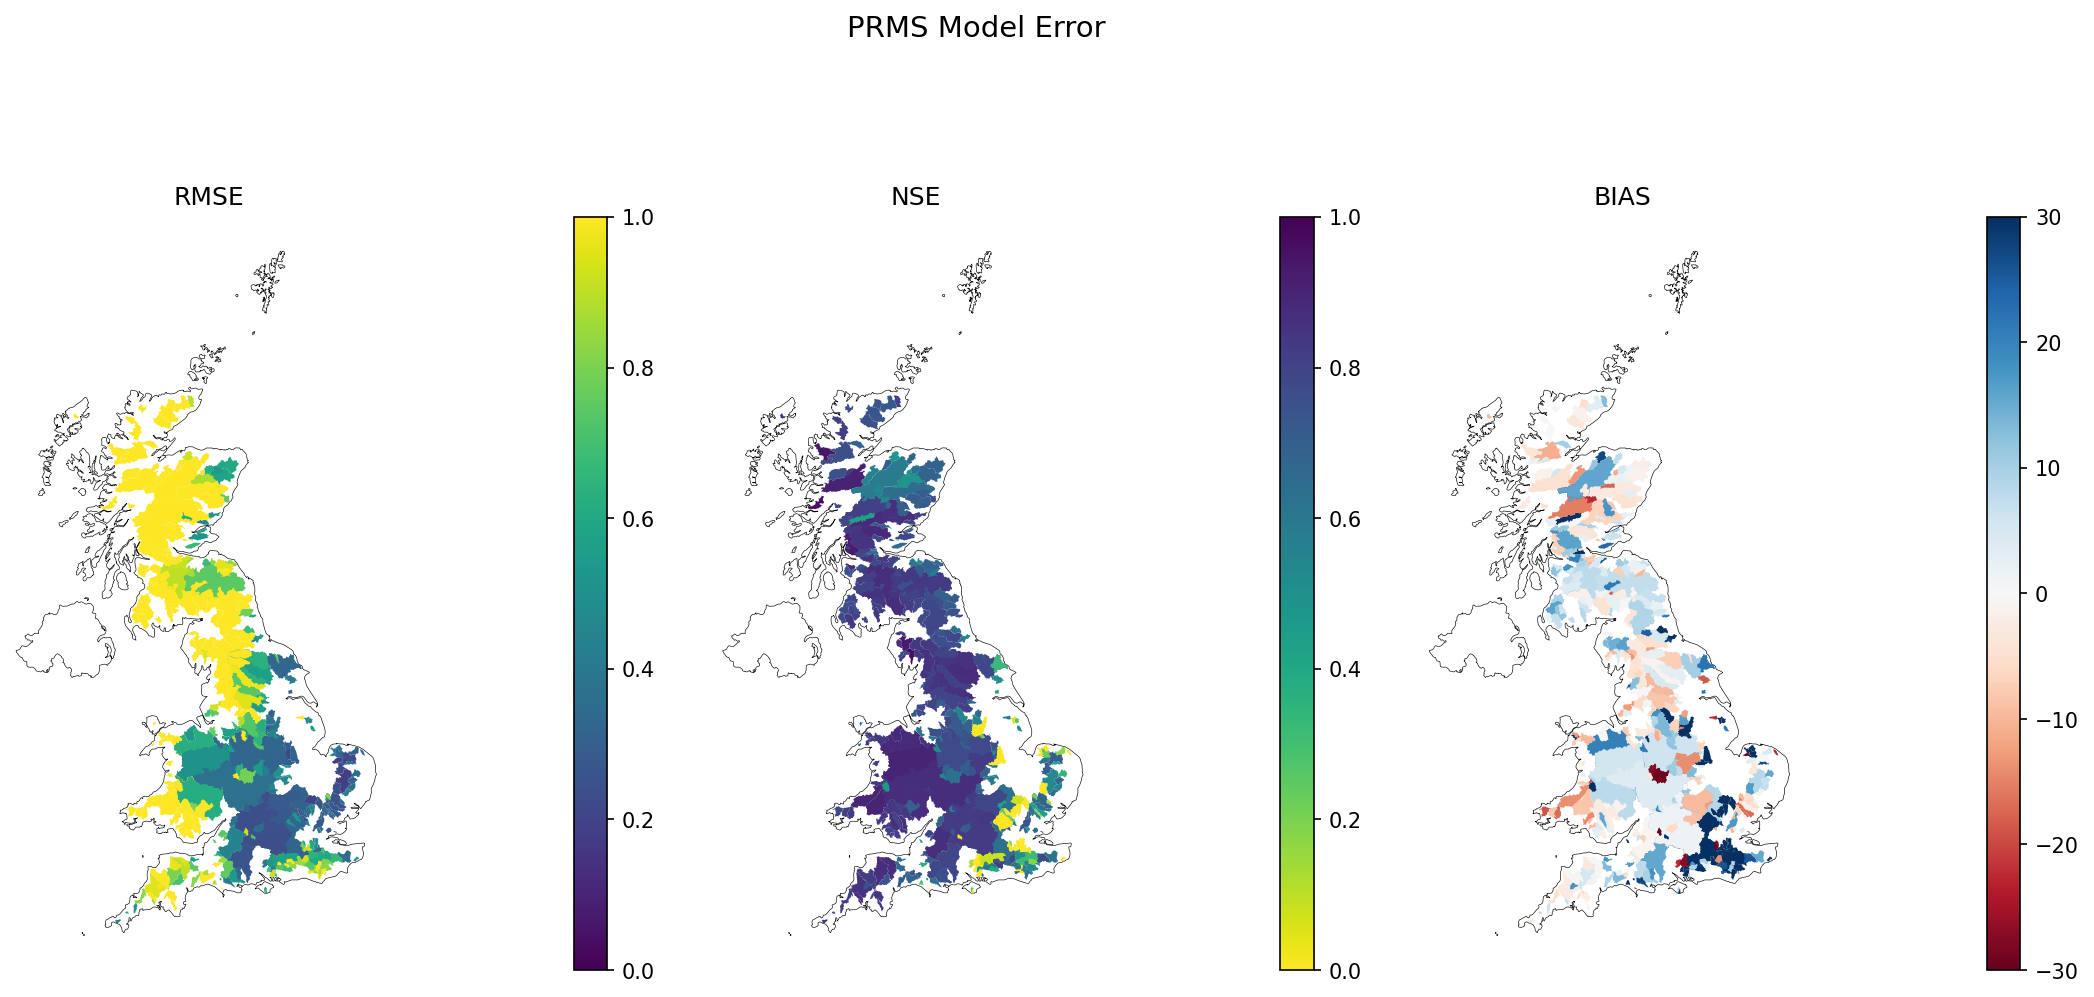

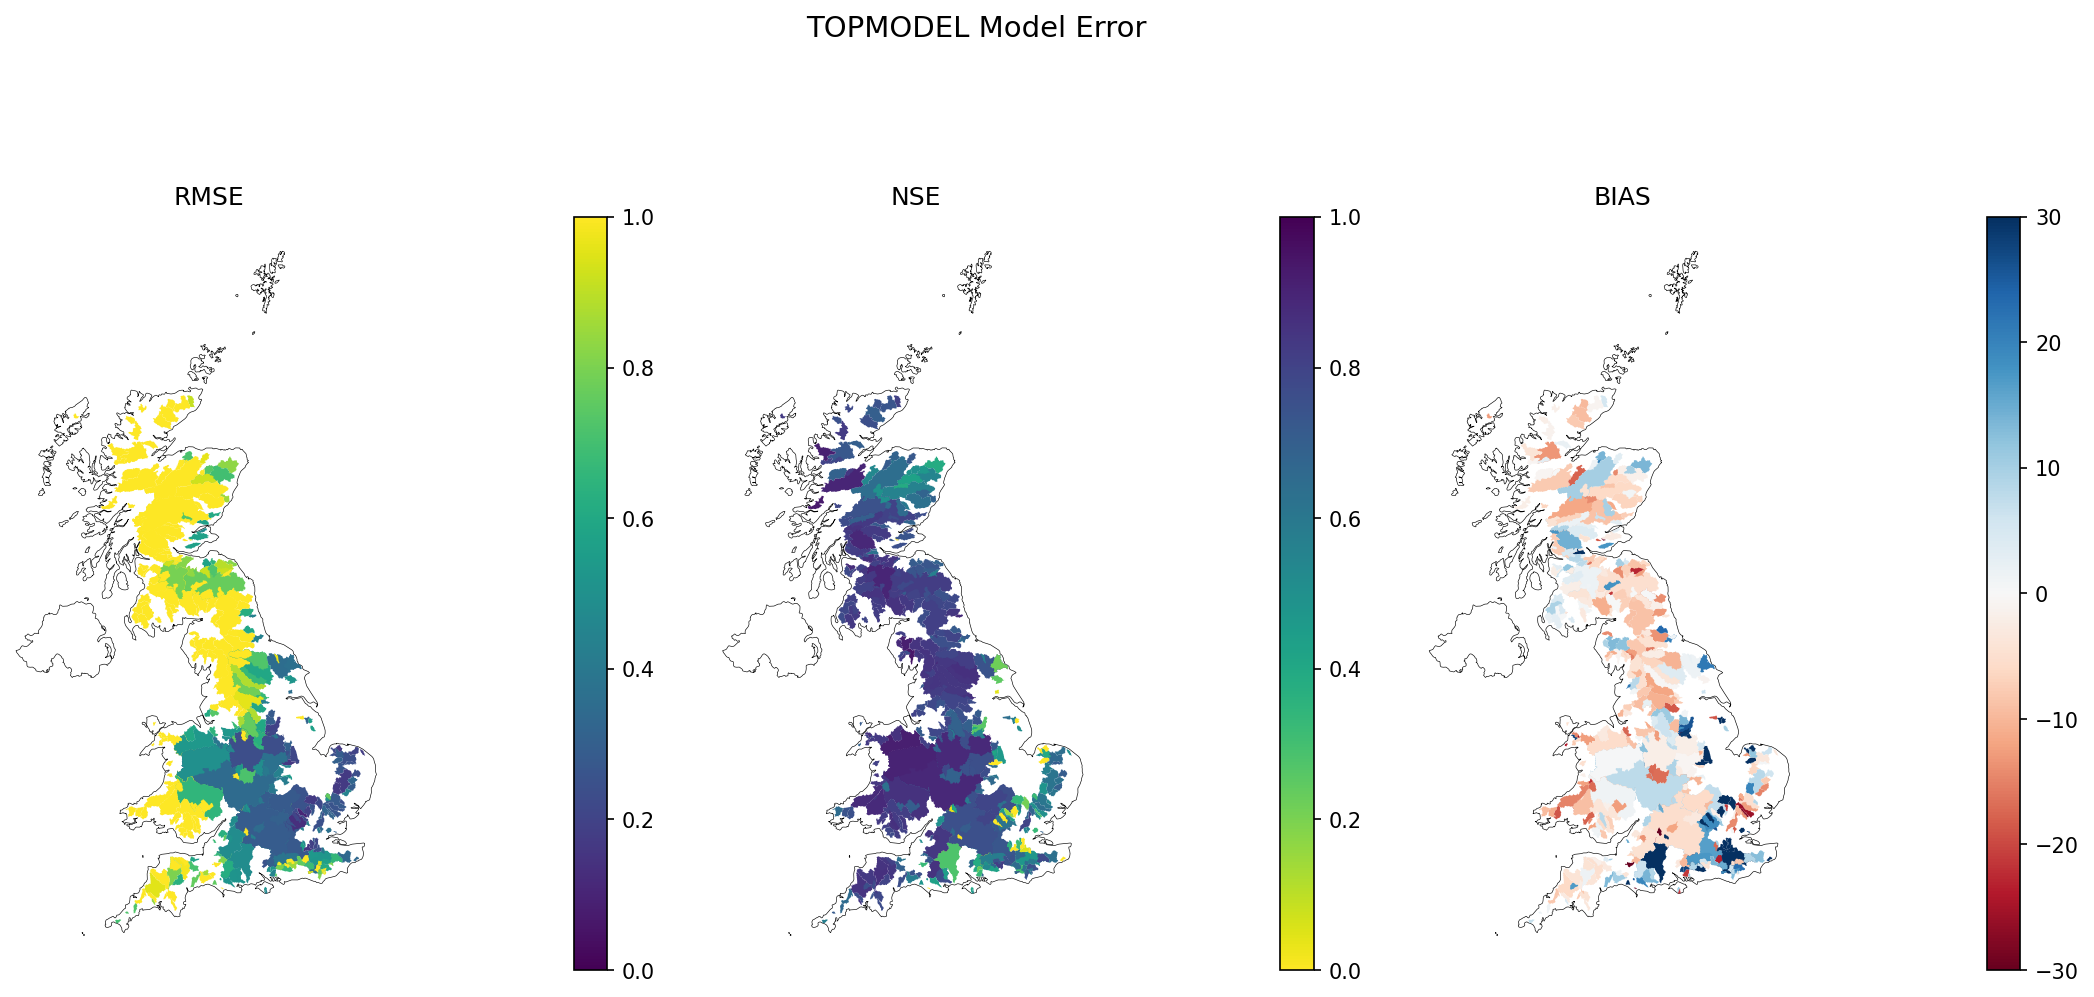

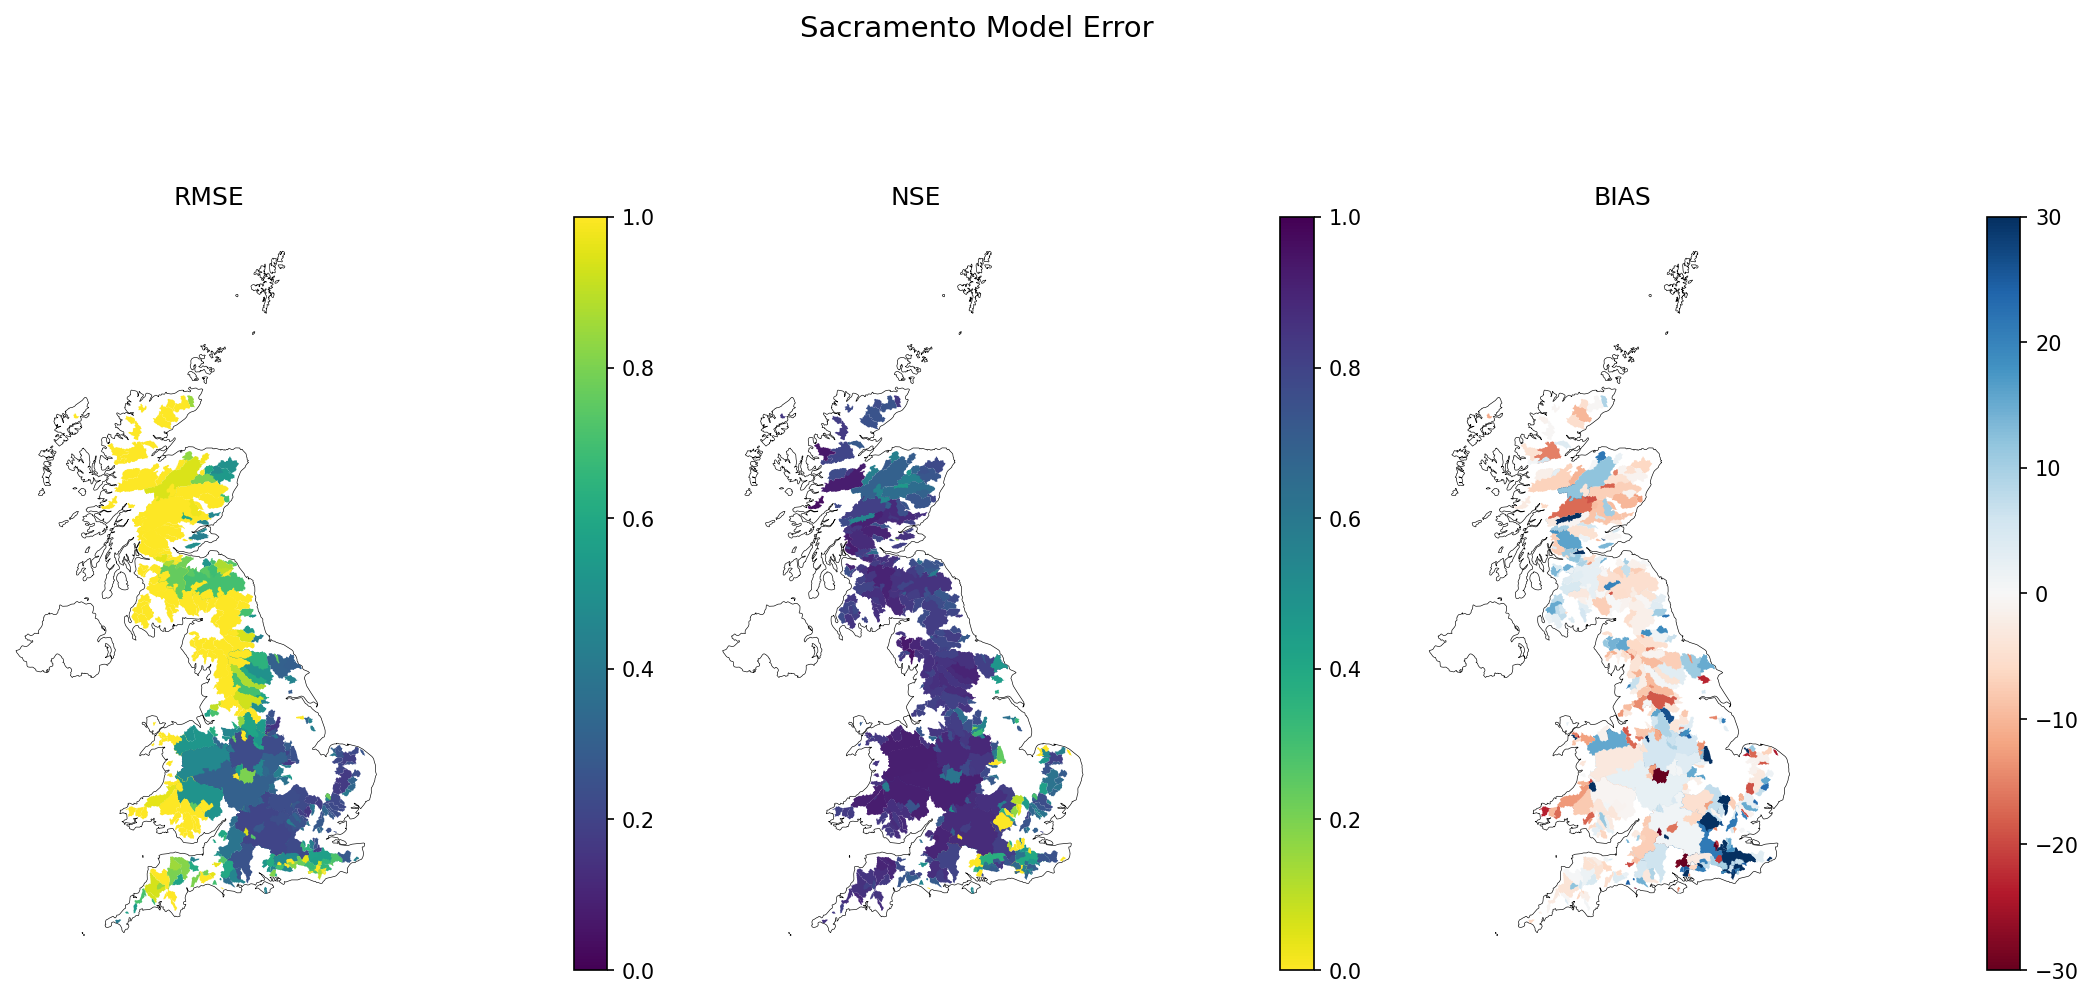

In [51]:
plot_geospatial_data(vic_gdf, model="VIC")
plot_geospatial_data(prms_gdf, model="PRMS")
plot_geospatial_data(top_gdf, model="TOPMODEL")
plot_geospatial_data(sac_gdf, model="Sacramento")